In [3]:
#необходимые пакеты 
import ee, geemap, os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas as gpd 
import scipy

In [ ]:
#geemap.update_package()


In [ ]:
ee.Initialize()

### Границы региона 

In [ ]:
region_boundary = geemap.geojson_to_ee('data/budenovsk_district_boundaries.geojson')

Budenovsk = geemap.Map(zoom = 10)

Budenovsk.centerObject(region_boundary)

Budenovsk.addLayer(region_boundary ,{'color' : "FF0000"}, 'Границы региона' )

Budenovsk

### подготовка коллекции для дальнейшей обработки

In [ ]:
# возьмем коллекцию сентинел и обработаем ее немного
def masking(img) : 
    cloudProb = img.select('MSK_CLDPRB')  # покрытие облаками
    snowProb = img.select('MSK_SNWPRB') # покрытие снегом
    cloud = cloudProb.lt(1) # создали бинарную маску иными словами просто все что имеет значение меньше 5 одна группа выше другая
                            # а мы помним что пиксели принимают значения от 0 до 255
    snow = snowProb.lt(1) # тоже самое что с облаками
    scl = img.select('SCL') # слой с классификатором(есть в sentinel 2 уровня обработки 2А)
    shadow = scl.neq(3);# 3 в классификации это тени от облаков
    cirrus_medium = scl.neq(8) # тоже по классификации облака 
    cirrus_high = scl.neq(9) # аналогично облака
    cirrus = scl.neq(10); # 10 это перистые облака или цирусы
    masked_img = img.updateMask(cloud).updateMask(shadow).updateMask(cirrus).updateMask(cirrus_medium).updateMask(cirrus_high)
    return(masked_img)

def clipper_region(image):
    clipped = image.clip(region_boundary.geometry())
    return  clipped 

#создали коллекцию с изображениями
start = ee.Date('2018-09-01')
finish = ee.Date('2019-09-01')
sentinel2_collection = ee.ImageCollection('COPERNICUS/S2_SR') \
    .filterBounds(region_boundary.geometry()) \
    .filterMetadata("CLOUD_COVERAGE_ASSESSMENT", 'less_than', 20.0) \
    .filterMetadata('SNOW_ICE_PERCENTAGE','less_than', 5.0) \
    .filterDate(start, finish)  \
    .map(masking).map(clipper_region)
sentinel2_collection_list = sentinel2_collection.toList(sentinel2_collection.size().getInfo())

#вынимаем уникальные даты из датасета
sentinel2_collection_list = sentinel2_collection.toList(sentinel2_collection.size().getInfo())
sentinel2_time_list = []
for i in range(sentinel2_collection.size().getInfo()):
    img = ee.Image(sentinel2_collection_list.get(i))
    time = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd').getInfo()
    sentinel2_time_list.append(time)

#уникальные даты из датасета
unique_dates = sorted(list(set(sentinel2_time_list)))

diff = finish.difference(start , 'day')
Range = ee.List.sequence(0, diff.subtract(1)).map(lambda day :  start.advance(day,'day'))
def day_mosaics(date , newlist):
    date = ee.Date(date)
    newlist = ee.List(newlist)
    
    filtered = sentinel2_collection.filterDate(date , date.advance(1,'day'))
    
    image = ee.Image(filtered.mosaic())
    
    return ee.List(ee.Algorithms.If(filtered.size(), newlist.add(image), newlist))
sentinel2_collection_mosaic = ee.ImageCollection(ee.List(Range.iterate(day_mosaics, ee.List([]))))

In [ ]:
#визуал для сентинел 2 
visualization = {"min": 0.0, "max": 2000,"bands": ['B4', 'B3', 'B2']}

In [ ]:
def sentinel2_NDTI(image):
    NDTI = image.normalizedDifference(['B11', 'B12']).rename('NDTI')
    return image.addBands([NDTI])

MiniNDTI = sentinel2_collection_mosaic.map(sentinel2_NDTI).select('NDTI').min().rename('minNDTI').reproject(crs= 'EPSG:32638' , crsTransform = [60, 0, 300000, 0, -60, 5000040])





In [ ]:
Budenovsk.addLayer(MiniNDTI, {'min' : 0 , 'max' : 0.2, 'palette' :['FFFF00','FFF000','FF0000' ]}, "minNDTI") # добавили на карту

In [ ]:
Archangelskoe = gpd.read_file('data/archangelskoe_wgs84.geojson' )
Praskoveya = gpd.read_file('Data/praskoveya_wgs84.geojson')

Archangelskoe['type'] = 'PP'
Praskoveya['type'] = 'TT'

fields = Praskoveya.append(Archangelskoe)[['type','geometry']]
fields['number'] = [i for i in range(0,fields.shape[0])]
fields_ee = geemap.geopandas_to_ee(fields)




In [ ]:
Budenovsk.add_styled_vector(fields_ee, column = 'type',palette = ['00FF2A',"FF8001" ], layer_name = 'разные технологии обработки') 


In [ ]:

#minNDTI_DF = MiniNDTI.select('minNDTI').sampleRegions(fields_ee)
#geemap.ee_export_vector(minNDTI_DF, filename='C:/Users/User/Google Диск/python_notebooks/Archangelskoe_NDTI_project/Data/minNDTI.csv')



In [ ]:
minNDTI_pd_df = pd.read_csv('Data/minNDTI.csv')
minNDTI_pd_df

minNDTI_pd_df[['field_№', 'number']] = minNDTI_pd_df['system:index'].str.split('_', 1, expand=True)
minNDTI_pd_df = minNDTI_pd_df.drop(["system:index",'number' ], 1)

minNDTI_pd_df

In [ ]:
# проверка на нормальность тестом холмогорова 

#sns.set_style("whitegrid") 

sns.set_palette("prism_r")


def kholmogorov_norm_test(x):
    if scipy.stats.kstest(x, 'norm')[1] < 0.05:
        return('распределение отличается от нормального')
    else:
        return('распределение нормальное')
NDTI_sevoob_stats = minNDTI_pd_df[['type', 'minNDTI']].groupby(['type'] ).aggregate([np.count_nonzero, np.mean, np.median, kholmogorov_norm_test])

display(NDTI_sevoob_stats)

dentisty = sns.displot(minNDTI_pd_df, x='minNDTI',
                       hue="type", 
                       kind="kde", 
                       fill=True)

x = minNDTI_pd_df[minNDTI_pd_df.type == 'TT']["minNDTI"]
y = minNDTI_pd_df[minNDTI_pd_df.type != 'TT']["minNDTI"]
if scipy.stats.kruskal(x,y)[1] < 0.05:
    res = 'выборки различаются'
else:
    res = 'выборки не различаются'
print(f'{res} при p уровне значимости {scipy.stats.kruskal(x,y)[1]}')    
    

#### Короткое резюме 
все отлично получилось , различия между выборками есть
1) нужно посмотреть другие годы , и покрасивее сделать графику 
2) переходить к анализу по культурам (нужно будет делать кластерный анализ по группам 

### Работа по кластерам


мы получили данные по группам, сейчася их добавлю и будем думать что делать дальше 

In [4]:
CLUSTER_NDVI = pd.read_csv('Data/RESULT_CLUSTER_NDVI_DATA.csv')


### Визуализация того что получилось по кластерам

In [14]:
CLUSTER_NDVI[CLUSTER_NDVI["type"] == 'TT']

,Unnamed: 0,2019-02-18,2019-06-10,2018-11-01,2018-12-03,2019-07-12,2019-08-13,2018-09-14,2019-03-22,2019-04-23,...,2019-05-09,2018-10-16,2018-11-17,number,groups,type,PC_1_45%,PC_2_20%,PC_3_16%,geometry
0,0,0.19470,0.2031,0.28960,0.3067,0.1940,0.20150,0.39195,0.19670,0.23400,...,0.2612,0.34215,0.26215,0,пары,TT,-0.751252,-2.057423,5.609323,"POLYGON ((44.25442671750923 44.69241974700958,..."
1,1,0.19145,0.3541,0.19850,0.2460,0.2606,0.32885,0.19985,0.26540,0.67385,...,0.8120,0.20250,0.21030,1,яровые,TT,-0.297509,2.055803,-2.450094,"POLYGON ((44.29948463248682 44.66838645255675,..."
2,2,0.19140,0.5453,0.20260,0.2465,0.2809,0.37840,0.19380,0.23310,0.53370,...,0.7733,0.19800,0.22430,2,яровые,TT,-0.701424,4.175954,-2.549742,"POLYGON ((44.29993979455907 44.66800920805998,..."
3,3,0.18560,0.5579,0.19395,0.2445,0.2712,0.33550,0.18590,0.22385,0.54115,...,0.7871,0.20180,0.16720,3,яровые,TT,-0.935236,3.182421,-2.312280,"POLYGON ((44.30986703105519 44.66254449505878,..."
4,4,0.18740,0.5689,0.21450,0.2574,0.2605,0.31270,0.19080,0.24580,0.57080,...,0.8226,0.21240,0.13820,4,яровые,TT,-0.767149,2.681731,-2.218020,"POLYGON ((44.32021065572656 44.65721294382791,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,115,0.18770,0.1888,0.22660,0.1924,0.1969,0.19265,0.23295,0.19235,0.21090,...,0.2363,0.23940,0.19690,115,пары,TT,-2.585259,-2.252816,2.028812,"POLYGON ((44.40298111569551 44.65994853622001,..."
116,116,0.20000,0.2080,0.25390,0.2994,0.2113,0.19920,0.32410,0.19380,0.20280,...,0.2394,0.29390,0.23520,116,пары,TT,-1.554197,-2.124299,4.354419,"POLYGON ((44.42663591951715 44.66819666462224,..."
117,117,0.20270,0.5488,0.19320,0.2551,0.1879,0.19520,0.18600,0.32500,0.77240,...,0.8720,0.20150,0.20850,117,яровые,TT,0.173348,-0.643359,-2.263836,"POLYGON ((44.44265726625331 44.66779362193734,..."
118,118,0.22010,0.4293,0.21030,0.2958,0.1775,0.19320,0.18460,0.36640,0.79660,...,0.8783,0.21180,0.18250,118,яровые,TT,0.781050,-1.571620,-2.408173,"POLYGON ((44.45206625791161 44.66265020059283,..."


<AxesSubplot:xlabel='PC_1_45%', ylabel='PC_2_20%'>

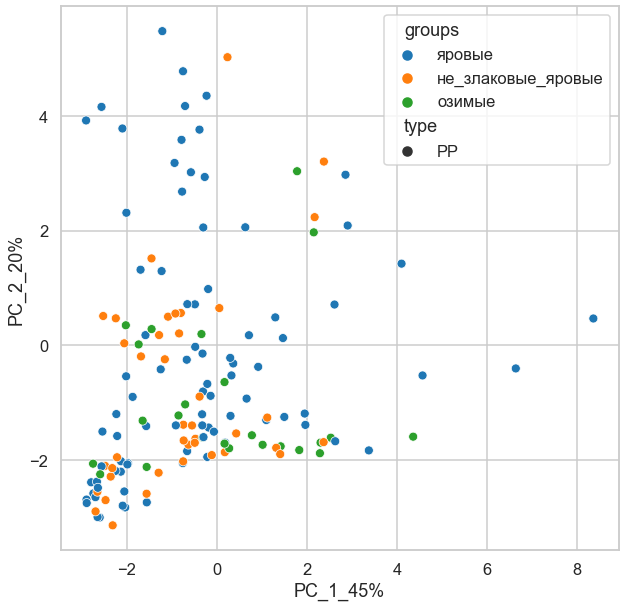

In [25]:
sns.set_context("talk")
sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols=1)
fig.set_size_inches(10, 10)
sns.scatterplot(data=CLUSTER_NDVI[CLUSTER_NDVI["type"] == 'PP'], x="PC_1_45%", y="PC_2_20%", hue="groups",style = 'type')


<AxesSubplot:xlabel='PC_1_45%', ylabel='PC_2_20%'>

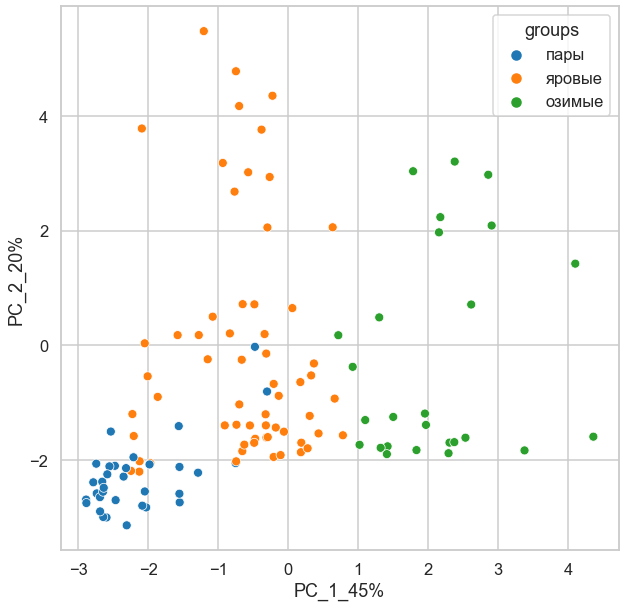

In [24]:
sns.set_context("talk")
sns.set_style("whitegrid")
fig, axs = plt.subplots(ncols=1)
fig.set_size_inches(10, 10)
sns.scatterplot(data=CLUSTER_NDVI[CLUSTER_NDVI["type"] == 'TT'], x="PC_1_45%", y="PC_2_20%", hue="groups")